# Overview
In this workbook, we'll leverage Sklearn's TFIDF vectorizer and MiniBatchKmeans to perform some simple document clustering. After which , we'll plot the clusters using PCA and TSNE, then show the top keywords in each cluster.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Importing the data
Importing the data is simple with Pandas. The source file is a newline delimited JSON file

In [2]:
data = pd.read_json('../input/combined.json', lines=True)
data.head()

,components,contents,date,id,title,topics
0,[National Security Division (NSD)],"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01 04:00:00,None,Convicted Bomb Plotter Sentenced to 30 Years,[]
1,[Environment and Natural Resources Division],WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25 04:00:00,12-919,$1 Million in Restitution Payments Announced t...,[]
2,[Environment and Natural Resources Division],BOSTON– A $1-million settlement has been...,2011-08-03 04:00:00,11-1002,$1 Million Settlement Reached for Natural Reso...,[]
3,[Environment and Natural Resources Division],WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08 05:00:00,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,[]
4,[Environment and Natural Resources Division],"The U.S. Department of Justice, the U.S. Envir...",2018-07-09 04:00:00,18-898,$100 Million Settlement Will Speed Cleanup Wor...,[Environment]


## Extracting keywords
Here I use the TfidfVectorizer since I'm hoping the IDF score will pull out unique words that I can use in clustering. There are lots of options to explore here to get different results, including CountVectorizer

In [3]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(data.contents)
text = tfidf.transform(data.contents)

## Finding Optimal Clusters
Clustering is an unsupervised operation, and KMeans requires that we specify the number of clusters. One simple approach is to plot the SSE for a range of cluster sizes. We look for the "elbow" where the SSE begins to level off. MiniBatchKMeans introduces some noise so I raised the batch and init sizes higher. Unfortunately the regular Kmeans implementation is too slow. You'll notice different random states will generate different charts. Here I chose 14 clusters.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


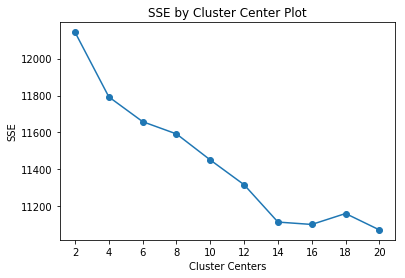

In [4]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [5]:
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

## Plotting Clusters
Here we plot the clusters generated by our KMeans operation. One plot uses PCA which is better at capturing global structure of the data. The other uses TSNE which is better at capturing relations between neighbors. In order to speed up the process with TSNE, I sample from 3,000 documents and perform a PCA 50 dimension reduction on the data first. Next I show a scatterplot further sampling the sample down to 300 points.

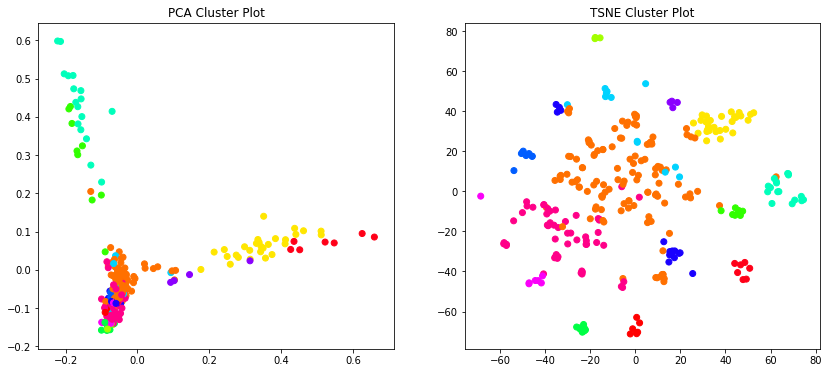

In [6]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)
    

## Top Keywords
Lastly, we'll cycle through the clusters and print out the top keywords based on their TFIDF score to see if we can spot any trends. I'll do this by computing an average value across all dimensions in Pandas, grouped by the cluster label. Using numpy, finding the top words is simply sorting the average values for each row, and taking the top N.

You can see that we have a pretty good result. Topics including exploitation of children, tax fraud, civil rights, and environmental issues can be inferred from the top keywords. Other interesting approaches to this might include LDA topic modeling or possibly working with pre-trained word embeddings.

In [7]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
images,sexual,children,ceos,safe,project,exploitation,childhood,pornography,child

Cluster 1
fbi,states,office,united,fraud,indictment,department,criminal,district,attorney

Cluster 2
revenue,division,refunds,taxes,attorney,false,income,returns,irs,tax

Cluster 3
hotline,provision,status,800,citizenship,immigration,ina,employment,discrimination,osc

Cluster 4
patients,medicaid,fraud,services,false,settlement,medicare,claims,care,health

Cluster 5
department,civil,lawsuit,rights,act,disabilities,hud,discrimination,fair,housing

Cluster 6
beneficiaries,home,strike,oig,services,care,hhs,fraud,health,medicare

Cluster 7
division,foreclosure,mortgage,task,rigging,bid,auctions,fraud,financial,antitrust

Cluster 8
county,police,ms,texas,abt,aka,murder,racketeering,members,gang

Cluster 9
environment,act,pollution,oil,clean,air,water,environmental,epa,settlement

Cluster 10
banks,undeclared,offshore,ubs,irs,account,tax,swiss,bank,accounts

Cluster 11
act,department,514,agreement,acc